In [73]:
import numpy as np 
import pandas as pd 
from sklearn.decomposition import PCA

In [48]:
orders = pd.read_csv("orders.csv")
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [49]:
prior = pd.read_csv('order_products__prior.csv')
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [50]:
train = pd.read_csv('order_products__train.csv')
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [51]:
products = pd.read_csv('products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [52]:
aisles = pd.read_csv('aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


## Since the dataset is huge(32.4M rows), currently working on small portion(1M rows) of dataset to reduce the computations.

In [65]:
new_prior = prior[0:1000000]
print(new_prior.shape)
new_prior.head()

(1000000, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [66]:
final_df = pd.merge(new_prior,products, on = ['product_id','product_id'])
final_df = pd.merge(final_df,orders,on=['order_id','order_id'])
final_df = pd.merge(final_df,aisles,on=['aisle_id','aisle_id'])
print(final_df.shape)
final_df.head(10)

(1000000, 14)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs
5,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.0,eggs
6,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.0,eggs
7,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.0,eggs
8,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.0,eggs
9,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.0,eggs


## Quick Overview on products sold and uniqueness.

In [67]:
#The most sold product is banana followed by bag of organic bananas and so on
final_df['product_name'].value_counts()[0:5]

Banana                    14759
Bag of Organic Bananas    11867
Organic Strawberries       8138
Organic Baby Spinach       7477
Organic Hass Avocado       6551
Name: product_name, dtype: int64

In [69]:
#Top 5 aisles categories
final_df['aisle'].value_counts()[0:5]

fresh fruits                  112409
fresh vegetables              105047
packaged vegetables fruits     54781
yogurt                         44674
packaged cheese                30184
Name: aisle, dtype: int64

## Clustering 
Want to find a possible clusters among the different customers and substitute single user_id with the cluster to which they are assumed to belong. Hence creating a dataframe with all the purchases made by each user

In [71]:
customer_prod = pd.crosstab(final_df['user_id'], final_df['aisle'])
print(customer_prod.shape)
customer_prod.head(10)

(67036, 134)


aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
19,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,0,1,0,0,0,0,0,0,0,2,...,1,1,0,0,0,0,0,1,0,2
23,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,4
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,4
32,0,0,0,0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,6


Here we can see that there are approximately 67k unique users and 134 aisles

# Model 1 --> Clustering by reducing the no of dimensions, i.e, PCA
# Model 2 --> Clustering based on TF-IDF 

In [76]:
#Model 1
#Trial n error for choosing no of principal components 
pca = PCA(n_components=10)
pca.fit(customer_prod)
sample_pca = pca.transform(customer_prod)
reduced_df = pd.DataFrame(sample_pca)
reduced_df.head()

,0,1,2,3,4,5,6,7,8,9
0,-2.708971,-0.392952,-0.156048,-0.267598,0.048999,-0.034093,0.043512,0.406598,-0.612522,-0.558052
1,-0.839879,0.891380,-1.150737,0.511672,-0.320159,-1.290652,0.465267,0.230754,-0.037028,0.045385
2,13.039217,-6.704655,2.144088,3.215836,-1.076651,-1.958363,-2.278263,-1.949281,1.854717,-1.016182
3,-2.626768,-0.464926,-0.157908,-0.244034,0.115513,-0.135981,-0.119568,-0.013582,0.100251,-0.053666
4,-1.313385,0.168963,-0.432725,0.729376,-0.095751,-0.741536,-0.640099,-0.414260,0.181023,-0.240876


(51895, 2)
          4         1
0 -0.424136  0.927294
1 -0.338025 -6.276388
2  0.066175 -0.472654
3 -0.336785  1.178279
4 -0.503145  1.337550


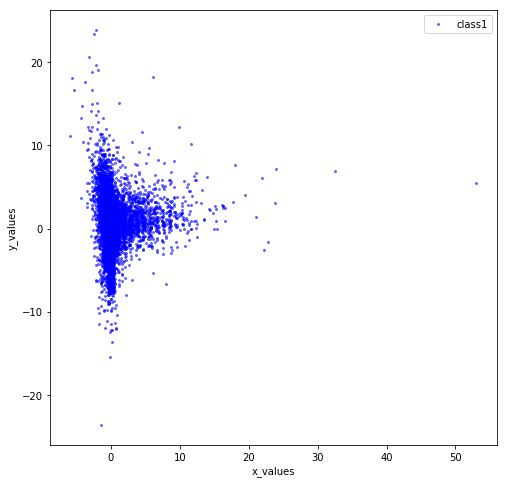

In [82]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
tocluster = pd.DataFrame(ps[[4,1]])
print (tocluster.shape)
print (tocluster.head())

plt.figure(figsize=(8,8))
plt.plot(tocluster[4], tocluster[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [79]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=8,random_state=1).fit(tocluster)